## Computing the best parameters for each of the four classifiers for the baseline evaluation

In [3]:
''' Importing the dataset in python '''

# pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 

# fetch dataset 
darwin = fetch_ucirepo(id=732) 
  
# data (as pandas dataframes) 
X = darwin.data.features 
y = darwin.data.targets 

## Let's start from Decision Tree

Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


C:\Users\gabri\anaconda3\envs\DMML\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


Best Parameters:
{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.7428571428571429
Precision: 0.6956521739130435
Recall: 0.8888888888888888
F1-Score: 0.7804878048780488


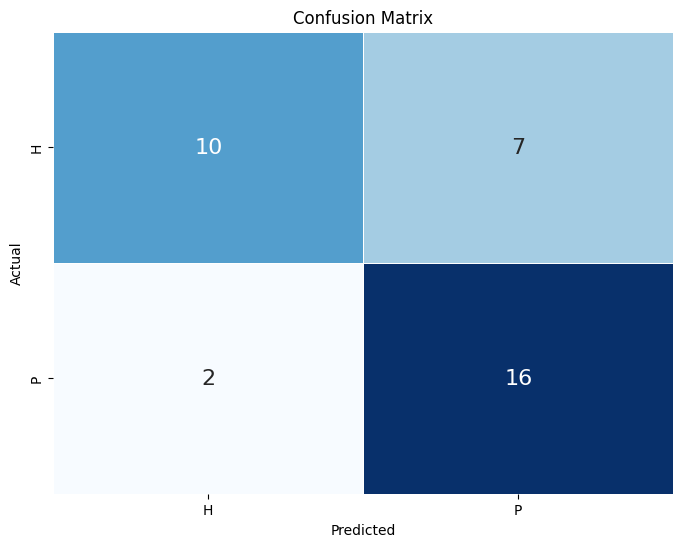

In [6]:
''' k-fold cross validation (k=5) grid search'''
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Definition of the classifier
clf = DecisionTreeClassifier(random_state=42)

# Definition of the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(2, 11)),
    'min_samples_split': list(range(2, 6)),
    'min_samples_leaf': list(range(2, 21, 2)),
    'max_leaf_nodes': list(range(2, 21, 2))
}

# Configuration of Grid Search with 5-fold Cross Validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='f1')

# Splitting the dataset into training and test sets
X_without_ID = X.drop(columns=['ID']) # the ID is not needed for classification
X_train, X_test, y_train, y_test = train_test_split(X_without_ID, y, test_size=0.2, random_state=42, stratify=y)

# Fitting the Grid Search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:")
print(grid_search.best_params_)

# Best model
best_clf = grid_search.best_estimator_

# Predictions with the best model
y_pred = best_clf.predict(X_test)

# Calculation and display of performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='P')
recall = recall_score(y_test, y_pred, pos_label='P')
f1 = f1_score(y_test, y_pred, pos_label='P')
cm = confusion_matrix(y_test, y_pred, labels=['H', 'P'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Print the confusion matrix
def plot_confusion_matrix(cm, labels):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                annot_kws={"size": 16}, linewidths=.5)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, labels=['H', 'P'])


### **Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}**

### We can also perform Nested Cross-validation:

In [ ]:
''' Nested cross-validation '''
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, KFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Definition of the classifier
clf = DecisionTreeClassifier(random_state=42)

# Definition of the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(2, 11)),
    'min_samples_split': list(range(2, 6)),
    'min_samples_leaf': list(range(2, 21, 2)),
    'max_leaf_nodes': list(range(2, 21, 2))
}

# Configuration of Grid Search with 5-fold Cross Validation for parameter selection
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=inner_cv, n_jobs=-1, verbose=1, scoring='f1')

# Configuration of Outer Cross Validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Execute Grid Search to find the best parameters
grid_search.fit(X_without_ID, y)

# Function to calculate additional metrics
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) if (conf_matrix[1, 1] + conf_matrix[1, 0]) > 0 else 0
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) > 0 else 0
    return precision, recall, f1, sensitivity, specificity, conf_matrix

# Perform nested cross-validation to get predictions with the best model
y_pred = cross_val_predict(grid_search.best_estimator_, X_without_ID, y, cv=outer_cv, method='predict')

# Calculate metrics
precision, recall, f1, sensitivity, specificity, conf_matrix = calculate_metrics(y, y_pred)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Print the best parameters found by Grid Search
print(f"Best Parameters: {grid_search.best_params_}")

### We have executed it in another notebook and got the same results as the normal k-fold cross validation.

**Note**: we performed all the following grid searches (for the other models) also with nested cross-validation, always finding the best attributes to be equal to the k-fold cross-validation ones. Thus, in the following of this notebook, only the codes for normal k-fold cross-validation are reported.

The codes that follow are the same as the k-fold cross-validation shown previously for Decision Tree: the only differences are of course the model used and the grid.

## Now let's move to Random Forest parameters evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Definition of the classifier
clf_rf = RandomForestClassifier(random_state=42)

# Definition of the parameter grid
param_grid_rf = {
    'max_depth': list(range(2, 11)),  # Maximum depth of the tree
    'n_estimators': list(range(50, 301, 50)),  # Number of trees in the forest
    'bootstrap': [True, False],  # Whether bootstrap samples are used
    'min_samples_split': list(range(2, 6)),  # Minimum number of samples required to split a node
    'min_samples_leaf': list(range(1, 21)),  # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

# Configuration of Grid Search with 5-fold Cross Validation
grid_search_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid_rf, 
                              cv=5, n_jobs=-1, verbose=1, scoring='f1')

# Splitting the dataset into training and test sets
X_without_ID = X.drop(columns=['ID'])  # The ID is not needed for classification
X_train, X_test, y_train, y_test = train_test_split(X_without_ID, y, test_size=0.2, random_state=42, stratify=y)

# Fitting the Grid Search
grid_search_rf.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:")
print(grid_search_rf.best_params_)

# Best model
best_rf_clf = grid_search_rf.best_estimator_

# Predictions with the best model
y_pred_rf = best_rf_clf.predict(X_test)

# Calculation and display of performance metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label='P')
recall_rf = recall_score(y_test, y_pred_rf, pos_label='P')
f1_rf = f1_score(y_test, y_pred_rf, pos_label='P')
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['H', 'P'])

print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1-Score: {f1_rf}")

# Print the confusion matrix
plot_confusion_matrix(cm_rf, labels=['H', 'P'])

## 	Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

## k-NN

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Classifier definition
clf = KNeighborsClassifier()

# Grid for hyperparameter tuning
param_grid = {
    'n_neighbors': list(range(1, 21)),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function for prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm for nearest neighbors
    'leaf_size': [10, 20, 30, 40, 50],  # Leaf size for specific algorithms
    'p': [1, 2],  # Power parameter for distance
    'metric': ['minkowski', 'euclidean', 'manhattan'],  # Distance metric
    'metric_params': [None]  # Additional metric parameters
}

# Configuring grid search with cross-validation (n_jobs = -1 uses all available cores)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='f1')

# Splitting data into train and test sets
X_without_ID = X.drop(columns=['ID'])  # Drop non-predictive ID column
X_train, X_test, y_train, y_test = train_test_split(X_without_ID, y, test_size=0.2, random_state=42, stratify=y)

# Fitting the grid search to the training data
grid_search.fit(X_train, y_train)

# Display the best parameters found
print("Best Parameters:")
print(grid_search.best_params_)

# Get best model predictions on the test set
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Compute and print performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='P')
recall = recall_score(y_test, y_pred, pos_label='P')
f1 = f1_score(y_test, y_pred, pos_label='P')
cm = confusion_matrix(y_test, y_pred, labels=['H', 'P'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

'''
# Confusion Matrix
def plot_confusion_matrix(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                annot_kws={"size": 16}, linewidths=.5)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, labels=['H', 'P'])
'''

## Best Parameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

## Gaussian Naive Bayes 

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Definition of the classifier
clf = GaussianNB()

# Definition of the parameter grid (GaussianNB has only one parameter, var_smoothing)
param_grid = {
    'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1]
}

# Configuration of Grid Search with 5-fold Cross Validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='f1')

# Splitting the dataset into training and test sets
X_without_ID = X.drop(columns=['ID']) # the ID is not needed for classification
X_train, X_test, y_train, y_test = train_test_split(X_without_ID, y, test_size=0.2, random_state=42, stratify=y)

# Fitting the Grid Search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:")
print(grid_search.best_params_)

# Best model
best_clf = grid_search.best_estimator_

# Predictions with the best model
y_pred = best_clf.predict(X_test)

# Calculation and display of performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='P')
recall = recall_score(y_test, y_pred, pos_label='P')
f1 = f1_score(y_test, y_pred, pos_label='P')
cm = confusion_matrix(y_test, y_pred, labels=['H', 'P'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Plot the confusion matrix
def plot_confusion_matrix(cm, labels):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                annot_kws={"size": 16}, linewidths=.5)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, labels=['H', 'P'])

## Best Parameters: {'var_smoothing': 1e-09}